In [3]:
import sys
sys.path.append("D:/RL_Finance/Reinforcement_learning")

In [4]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

import plotting
from envs.blackjack import BlackjackEnv

matplotlib.style.use('ggplot')

c:\Users\xiang\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
## dynamically improve the policy with dynamically changing value function Q

def mc_epsilon_greedy_policy(Q, epsilon ,nA):

    def policy(observation):
        A=np.ones(nA,dtype=float) * epsilon / nA
        max_action=np.argmax(Q[observation])

        A[max_action] = A[max_action] + (1-epsilon)

        return A
    
    return policy

In [6]:
def mc_control_greedy_policy(env, num_episodes, discount_factor=1.0, epsilon=0.1):


    return_sum=defaultdict(float)
    return_count=defaultdict(float)

    ## initilize the value function:
    Q=defaultdict(lambda: np.zeros(env.action_space.n))

    ## initilize the policy:
    policy=mc_epsilon_greedy_policy(Q, epsilon ,env.action_space.n)


    for i in range(num_episodes):
        episode=[]
        state=env.reset()

        for t in range(100):
            probs=policy(state) ## a prob distribution over action, once Q changes, policy would improve
            action=np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append([state,action,reward])
            if done:
                break

            state=next_state

        ## After generating one specific episode, we need to provide the value update on this episode
        ## but we need to use another for loop to get the value update for each state met in this episode
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])

        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            return_sum[sa_pair] += G
            return_count[sa_pair] += 1.0
            Q[state][action] = return_sum[sa_pair] / return_count[sa_pair]

            ## Now we finish update the value function for this episode
            ## once we call policy(state), the policy will be updated with this new value function

    return Q, policy
        


In [7]:
env=BlackjackEnv()

In [8]:
Q, policy = mc_control_greedy_policy(env, num_episodes=100000, epsilon=0.1)

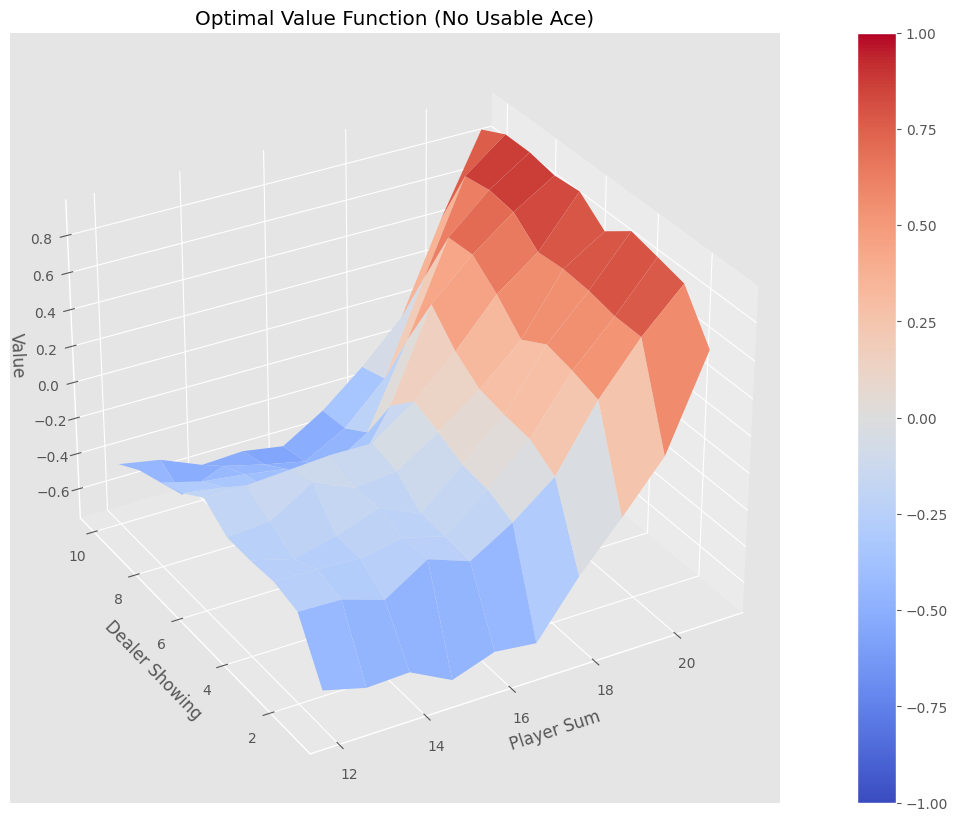

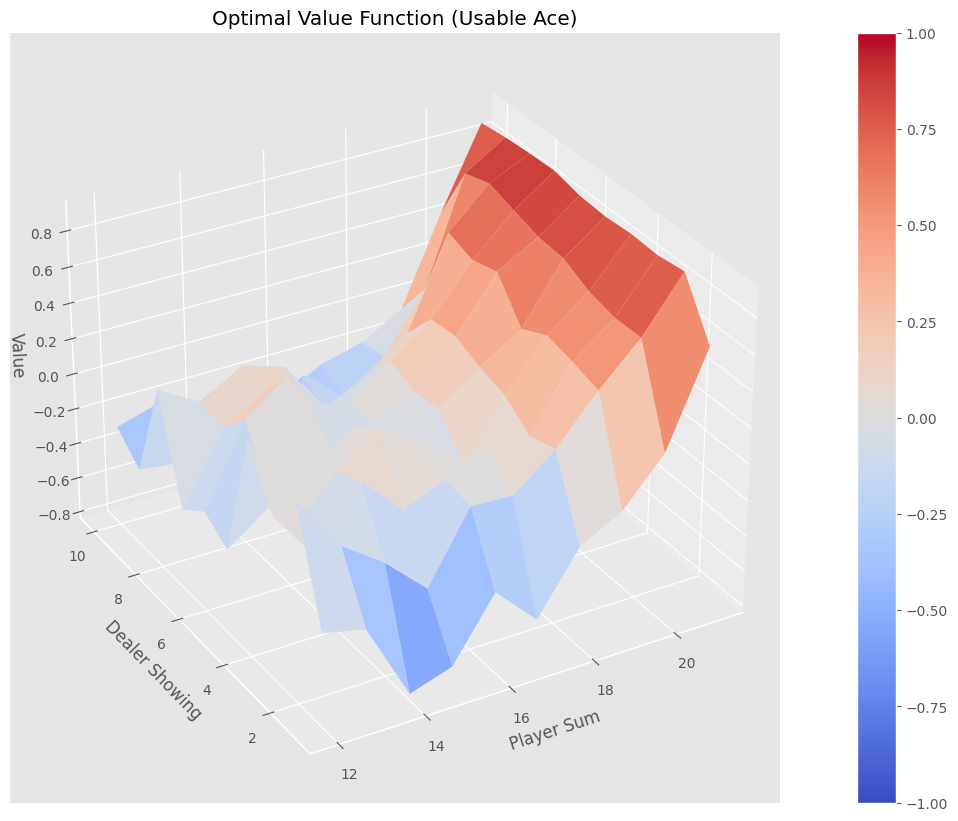

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")